In [1]:
# import statements
from scipy.integrate import ode, solve_ivp # ordinary diff equations solver
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [136]:
def generate_constants(time_range, constant):
    """Generates vector of constants in the size of time_range. 

    Args:
        time_range (int): Time range or vector length.
        constant (float): Constant to be replicated.

    Returns:
        constants: Vector of constants.
    """  

    if type(time_range) is not int:
        raise Exception('Time range is not integer.')
    constants = constant * np.ones(time_range+1)

    return list(constants)

def functionize(arg, length):
    """If constant, transforms it into a function that returns the same value element-wise. If list of values, transforms it into a function that returns the values element-wise.

    Args:
        arg (list, float or int): Value to be transformed.
        length (int): Length of the returning vector.

    Raises:
        Exception: Invalid data types or incoherent lengths.

    Returns:
        arg_func (function): Lambda function returning element-wise.
        text_summary (string): String containing the summary values.
    """
    
    if type(length) is not int:
        raise Exception('Please provide an integer as length.')
    
    if any([type(arg) is float, type(arg) is int]):
        vec = generate_constants(length, arg)
        text_summary = str(round(np.mean(vec), 2))
    elif type(arg) is list:
        vec = arg[:length+1]
        text_summary = 'Mean: ' + str(round(np.mean(vec), 2))
    else:
        raise Exception('Please provide a number or a list.')
        
    arg_func = lambda x: vec[round(x)]
    
    return arg_func, text_summary

In [131]:
class seirv_model:
    """
    Intantiates a SEIRV object.
    Stands for: Susceptible, Exposed, Infected, Recovered and Vaccinated.
    """

    def __init__(self, N=1e3, time_range=10, **kwargs):
        """
        Initializes the model with default parameters.

        Args:
            N (int, optional): [Population size]. Defaults to 1e3.
            time_range (int, optional): [Simulation time in days]. Defaults to 10.
        """    
        # initializes model parameters
        self.time_range = time_range # simulation duration in days
        self.beta = 0.3 # time varying transmission rate, initial value
        self.Z = 3.69 # average time, in days, for exposed to become infected
        self.alpha = 0.6 # reported infections rate (Ir/Ir+In)
        self.D = 7.0 # average time, in days, for the infection duration. 
        self.eta = 0.1 # fixed reinfection rate
        self.gamma = 0.1 # vaccination rate

        # initializes infection parameters
        self.N = N # initial number of individuals in the population
        self.S = 0.9 * N # initial number of susceptible individuals
        self.E = 0.05 * N # initial number of exposed individuals
        self.Ir = 0.05 * N # initial number of reported infected individuals
        self.In = 0 * N # initial number of non-reported infected individuals
        self.R = 0 * N # initial number of recovered
        self.V = 0 * N # initial number of vaccinated

        for key, value in kwargs.items(): # updates model parameters, if any
            setattr(self, key, value)

        # checks if inputs are valid
        conditions = all([self.S <= self.N,
                          self.E <= self.N,
                          self.Ir <= self.N,
                          self.In <= self.N,
                          self.R <= self.N,
                          self.V <= self.N])
        if conditions:
            self.solution = self.solve_seir_function()
        else:
            raise Exception('Parameters are not valid.')


    def seir_function(self, t, y, beta, Z, alpha, D, eta, gamma):
        """
        Defines the function to be solved in the Initial Value Problem.

        Args:
            t (float): [Time to be varied]
            y ([array of floats]): [Contains the infection parameters]
            beta ([float]): [Transmission rate]
            Z ([float]): [Average time for infection, days]
            alpha ([float]): [Reported infections rate]
            D ([float]): [Average time for the infection duration, days]
            eta ([float]): [Fixed reinfection rate]
            gamma ([float]): [Vaccination rate]

        Returns:
            [array of floats]: [returns the deterministic equations]
        """        
        S, E, In, Ir, R, V = y

        # model compartments
        dSdt = (-beta(t)/self.N)*S*(In+Ir) + eta(t)*R - gamma(t)*S# susceptible individuals time varying rate
        dEdt = (beta(t)/self.N)*S*(In+Ir) - (1/Z(t))*E # exposed individuals time varying rate
        dIrdt = (alpha(t)/Z(t))*E - (1/D(t))*Ir # reported infections time varying rate
        dIndt = ((1-alpha(t))/Z(t))*E - (1/D(t))*In # non reported infections time varying rate
        dRdt = (1/D(t))*(In+Ir) - eta(t)*R # recovered individuals time varying rate
        dVdt = gamma(t)*S # total vaccinated individuals

        return np.array([dSdt, dEdt, dIrdt, dIndt, dRdt, dVdt])

    def solve_seir_function(self):
        """
        Solves the seir function based on initial values, uses scipy.integrate.

        Returns:
            [object]: [Solution object]
        """

        # decide if constants are time dependant or numbers
        # summaries are used for plotting the title
        self.beta, self.beta_summary = functionize(self.beta, self.time_range)
        self.Z, self.Z_summary = functionize(self.Z, self.time_range)
        self.alpha, self.alpha_summary = functionize(self.alpha, self.time_range)
        self.D, self.D_summary = functionize(self.D, self.time_range)
        self.eta, self.eta_summary = functionize(self.eta, self.time_range)
        self.gamma, self.gamma_summary = functionize(self.gamma, self.time_range)

        # solve the initial value problem
        solver = solve_ivp(self.seir_function,
                            [0, self.time_range],
                            [self.S, self.E, self.In, self.Ir, self.R, self.V],
                            t_eval = np.array(range(self.time_range)),
                            method = 'RK45',
                            args = [self.beta, self.Z, self.alpha, self.D, self.eta, self.gamma])
        return solver

    def plot_results(self, split_i=False):
        """
        Plots the results using matplotlib, based on object values.

        Args:
            split_i (bool, optional): [True if split between reported and non reported]. 
            Defaults to False.
        """        
        
        S_solved = self.solution.y[0]
        E_solved = self.solution.y[1]
        In_solved = self.solution.y[2]
        Ir_solved = self.solution.y[3]
        R_solved = self.solution.y[4]
        V_solved = self.solution.y[5]
        time_solved = self.solution.t

        if split_i:
            vals = [S_solved, E_solved, In_solved, Ir_solved, R_solved, V_solved]
            labels = ['S', 'E', 'In', 'Ir', 'R', 'V']
        else:
            vals = [S_solved, E_solved, In_solved + Ir_solved, R_solved, V_solved]
            labels = ['S', 'E', 'I', 'R', 'V']

        fig, ax = plt.subplots(figsize=(15,7))
        for var in vals:
            plt.plot(time_solved, var)
        plt.title('SEIR Model \n Initial Params: \n S=' + str(self.S) +        \
                  ', E=' + str(self.E) + ', In=' + str(self.In) +              \
                  ', Ir=' + str(self.Ir) + ', E=' + str(self.E) +              \
                  ', R=' + str(self.R) + ', V= ' + str(self.V) + 
                  \
                  ', \n Beta=' + str(self.beta_summary) +       
                  \
                  ', Alpha=' + str(self.alpha_summary) + 
                  \
                  ', Z=' + str(self.Z_summary) +        
                  \
                  ', D=' + str(self.D_summary) +
                  \
                  ', eta=' + str(self.eta_summary) +
                  \
                  ', gamma=' + str(self.gamma_summary))

        plt.legend(labels)

In [148]:
In = model.solution.y[2] # non reported
Ir = model.solution.y[3] # reported

In + Ir

array([ 0.        , 11.16733972, 18.85619143, 24.35251899, 28.3794603 ,
       31.36748504, 33.55430532, 35.08575623, 36.0720563 , 36.57520947,
       36.65315574, 36.3591312 , 35.72925056, 34.82713632, 33.71392573,
       32.43558802, 31.0229244 , 29.49163893, 27.88334436, 26.24156941,
       24.58442746, 22.93272349, 21.30995407, 19.74228127, 18.24395676,
       16.81103088, 15.44444171, 14.14860829, 12.93143071, 11.80058268,
       10.74888923,  9.77037005,  8.86184288,  8.022578  ,  7.25388238,
        6.55097182,  5.90701502,  5.3173779 ,  4.77887903,  4.28978963,
        3.84741003,  3.44645423,  3.08302679,  2.7540601 ,  2.45731434,
        2.19088497,  1.95142407,  1.73612578,  1.54269927,  1.36931774,
        1.21452997,  1.07637016,  0.95299415,  0.84287896,  0.74475608,
        0.65759431,  0.58023449,  0.51155161,  0.45060289,  0.39658334])

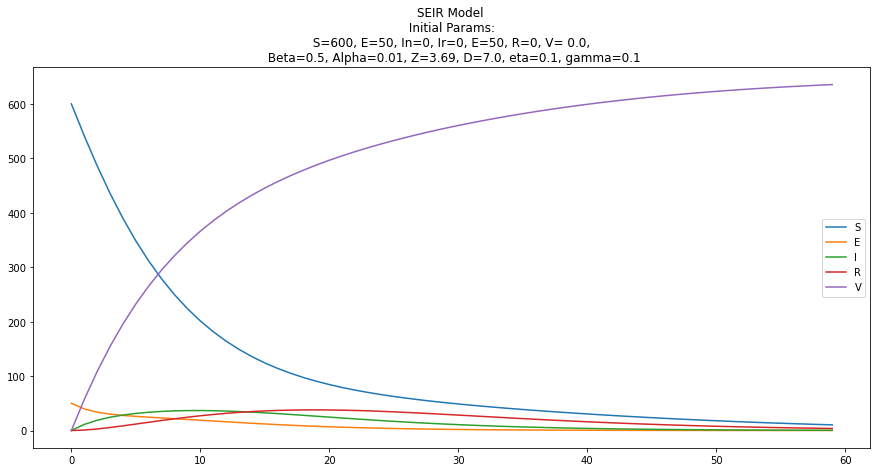

In [139]:
model = seirv_model(N = 1e3,
                   time_range = 60,
                   beta = 0.5,
                   alpha = 0.01,
                   S = 600,
                   E = 50,
                   In = 0,
                   Ir = 0,
                   R = 0)
model.plot_results(split_i=False)

Next steps:
- Figure out why Ir and In don't converge.
- Transform code into python packages